## Predictive Model for Water Level of the Chattooga River

TODO: ADD Image of the model here

As a whitewater kayaker, I take many trips to the Chattooga River. The water level is determined by the amount of rainfall in the area. It is important to know the water level of the river before making the trip, because if the water level is too high or too low, the river is not safe to take trips out. The goal of this project is to create a predictive model for the water level of the Chattooga River. This model will be used to predict the water level of the river for the next 24 hours. This will allow for an exploration of how predictive models work, using research to solve a problem, and provide a useful tool for me.

## Outline

## Data Collection

Data collection consited of two parts, the water level and the percipitation data. 

#### Water Level

The first part was collecting data from the USGS site. The USGS website contained data only back to 2007, which is a limiting factor, but it is the best data available for the Chattooga River. The data would specfically be take from one site, Chattooga River Near Clayton, GA, since this is the one most often used by us kayakers. Data is in the form of a text file, listing data about water levels every 15 min.

#### Weather Data

The second part of the data is the weather data. Rabun county was used as it is the location of the gauge we are using for the Chattooga River. The data was in the form of a csv, and contained data from 2007 to 2023, and contains data about weather pulled every day. 

#### Outline

ADD in all of the stuff about pulling data from USGS site enitially, but the issue was it was daily. Then running into the issue that 15 minute updates only went back to 2014. Then, used weather undergrounds api to access data from ashiway station, which is the closest station to the gauge. This could cause issue but we will see

## Data Processing

TODO: add more about data processing

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132256 entries, 2007-10-05 01:00:00 to 2023-05-29 17:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    132256 non-null  float64
 1   water   132256 non-null  float64
dtypes: float64(2)
memory usage: 3.0 MB


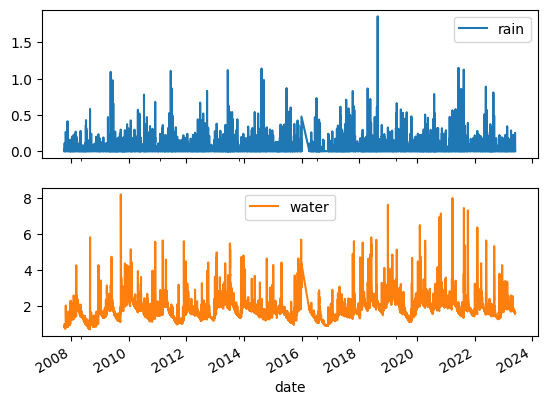

In [26]:
# This is the main file that will be used to run the project. Data pre-processing code can be seen in code/data-processing.py and code/scrape-precip-data.py
data = pd.read_csv('./data/combined_data.csv', parse_dates=['date'], index_col='date')

data.info()

# Plot the merged data (water level and precipitation)
data.plot(subplots=True)
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

X = data.drop(['water'], axis=1)
y = data['water']

# COuld do this programatically but this is an 80/20 split
train_data = data.loc['2007-10-05 01:00:00':'2020-05-09 14:00:00']
test_data = data.loc['2020-05-09 14:00:00':]

print(train_data)
print(test_data)

                       rain   water
date                               
2007-10-05 01:00:00  0.0000  0.8400
2007-10-05 02:00:00  0.0000  0.8400
2007-10-05 03:00:00  0.0000  0.8450
2007-10-05 04:00:00  0.0000  0.8500
2007-10-05 05:00:00  0.0225  0.8550
...                     ...     ...
2020-05-09 10:00:00  0.0000  2.1700
2020-05-09 11:00:00  0.0000  2.1700
2020-05-09 12:00:00  0.0000  2.1625
2020-05-09 13:00:00  0.0000  2.1600
2020-05-09 14:00:00  0.0000  2.1575

[105803 rows x 2 columns]
                     rain   water
date                             
2020-05-09 14:00:00   0.0  2.1575
2020-05-09 15:00:00   0.0  2.1500
2020-05-09 16:00:00   0.0  2.1500
2020-05-09 17:00:00   0.0  2.1400
2020-05-09 18:00:00   0.0  2.1400
...                   ...     ...
2023-05-29 13:00:00   0.0  1.6500
2023-05-29 14:00:00   0.0  1.6450
2023-05-29 15:00:00   0.0  1.6400
2023-05-29 16:00:00   0.0  1.6375
2023-05-29 17:00:00   0.0  1.6300

[26454 rows x 2 columns]


In [46]:
# Define the ARIMA model parameters
p = 1  # AR order
d = 0  # Integration order
q = 1  # MA order

# Create the ARIMA model
model = ARIMA(train_data['water'], order=(p, d, q))

# Fit the model to the training data, using the precipitation amount as an exogenous variable
model_fit = model.fit()

/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: SARIMAX models require univariate `endog`. Got shape (105803, 2).

In [45]:
# Specify the start and end dates for prediction
start_date = test_data.index[0]
end_date = test_data.index[-1]

print(model_fit.summary())

# Generate predictions for the specified date range, using the precipitation amount as an exogenous variable
predictions = model_fit.predict(start=start_date, end=end_date)

mse = np.mean((predictions - test_data['water_level']) ** 2)

                               SARIMAX Results                                
Dep. Variable:                  water   No. Observations:               105803
Model:                 ARIMA(1, 0, 1)   Log Likelihood              229975.389
Date:                Wed, 21 Jun 2023   AIC                        -459942.778
Time:                        11:27:40   BIC                        -459904.500
Sample:                             0   HQIC                       -459931.191
                             - 105803                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7454      0.065     26.847      0.000       1.618       1.873
ar.L1          0.9968      0.000   8709.962      0.000       0.997       0.997
ma.L1          0.5653      0.000   5003.741      0.0

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'